# Human-in-the-Loop Machine Learning: Final Project LLM Experiments

### Imports

In [1]:
# imports
import datasets
from openai import OpenAI
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data_utils import openai_iter_generation, get_demographic_system_prompt, get_annotator_demographic_dict, get_majority_vote, get_ds_format, get_identities_survey_prompt, get_extra_survey_prompts, openai_messages_format
from data_info import comment_annotations, response_to_num
from dawid_skene import run
from comment_annotator_ids import llm_filtered_comment_annotator_id

### 1. Loading the dataset from huggingface

In [2]:
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'default') 
filtered_dataset = dataset.filter(lambda instance: (instance['comment_id'], instance['annotator_id']) in llm_filtered_comment_annotator_id)

### 2. Majority Voting

In [3]:
comment_id_to_data = {}
for instance in filtered_dataset['train']:
    if instance['comment_id'] not in comment_id_to_data.keys():
        comment_id_to_data[instance['comment_id']] = {'comment': instance['text']}
        for axis in comment_annotations:
            comment_id_to_data[instance['comment_id']][axis] = []
    for axis in comment_annotations:
            comment_id_to_data[instance['comment_id']][axis].append(instance[axis])

# get data in axes format
axes_results = {}
for axis in comment_annotations:
    axes_results[axis] = []

# run majority voting
for id in comment_id_to_data:
    results = get_majority_vote(comment_id_to_data[id])
    for axis in comment_annotations:
        axes_results[axis].append(results[axis])

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.13333333, 0.26666667, 0.4       , 0.53333333,
        0.66666667, 0.8       , 0.93333333, 1.06666667, 1.2       ,
        1.33333333, 1.46666667, 1.6       , 1.73333333, 1.86666667,
        2.        , 2.13333333, 2.26666667, 2.4       , 2.53333333,
        2.66666667, 2.8       , 2.93333333, 3.06666667, 3.2       ,
        3.33333333, 3.46666667, 3.6       , 3.73333333, 3.86666667,
        4.        ]),
 <BarContainer object of 30 artists>)

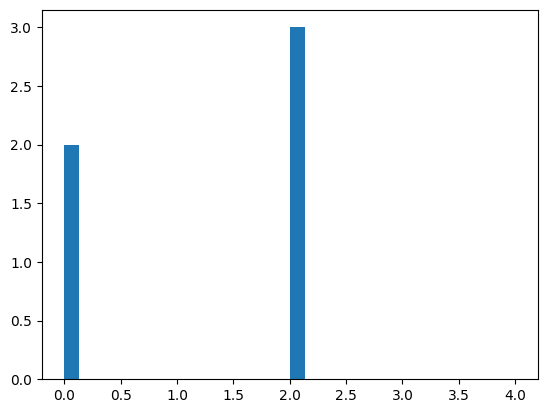

In [4]:
plt.hist(axes_results['hatespeech'], bins=30, range=[0, 4])

### 3. Dawid-Skene

In [5]:
# format data for dawid-skene code
ds_format_data = {}
for axis in comment_annotations:
    ds_format_data[axis] = get_ds_format(filtered_dataset['train'], axis)

# run dawid-skene
dawid_skene_results = {}
for axis in comment_annotations:
    dawid_skene_results[axis] = run(ds_format_data[axis])

# get argmax for each comment
ds_axes_results = {}
for axis in comment_annotations:
    ds_axes_results[axis] = [np.argmax(v) for k, v in dawid_skene_results[axis].items()]

/Users/miriam/Desktop/hitlml-project/dawid_skene.py:228: RuntimeWarning: overflow encountered in divide
  error_rates[k,j,:] = error_rates[k,j,:]/float(sum_over_responses)


(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.    , 0.1333, 0.2667, 0.4   , 0.5333, 0.6667, 0.8   , 0.9333,
        1.0667, 1.2   , 1.3333, 1.4667, 1.6   , 1.7333, 1.8667, 2.    ,
        2.1333, 2.2667, 2.4   , 2.5333, 2.6667, 2.8   , 2.9333, 3.0667,
        3.2   , 3.3333, 3.4667, 3.6   , 3.7333, 3.8667, 4.    ]),
 <BarContainer object of 30 artists>)

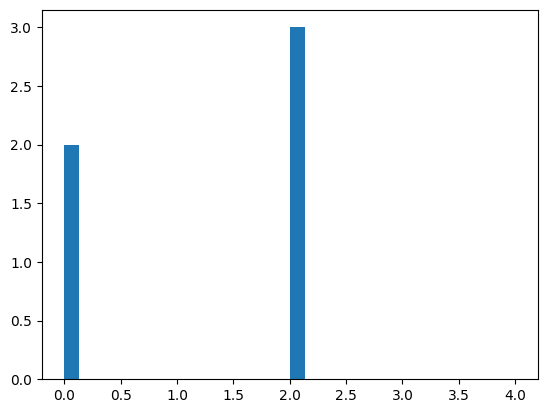

In [6]:
plt.hist(ds_axes_results['hatespeech'], bins=30,  range=[0, 4])

### 4. Plotting Majority voting and dawid-skene

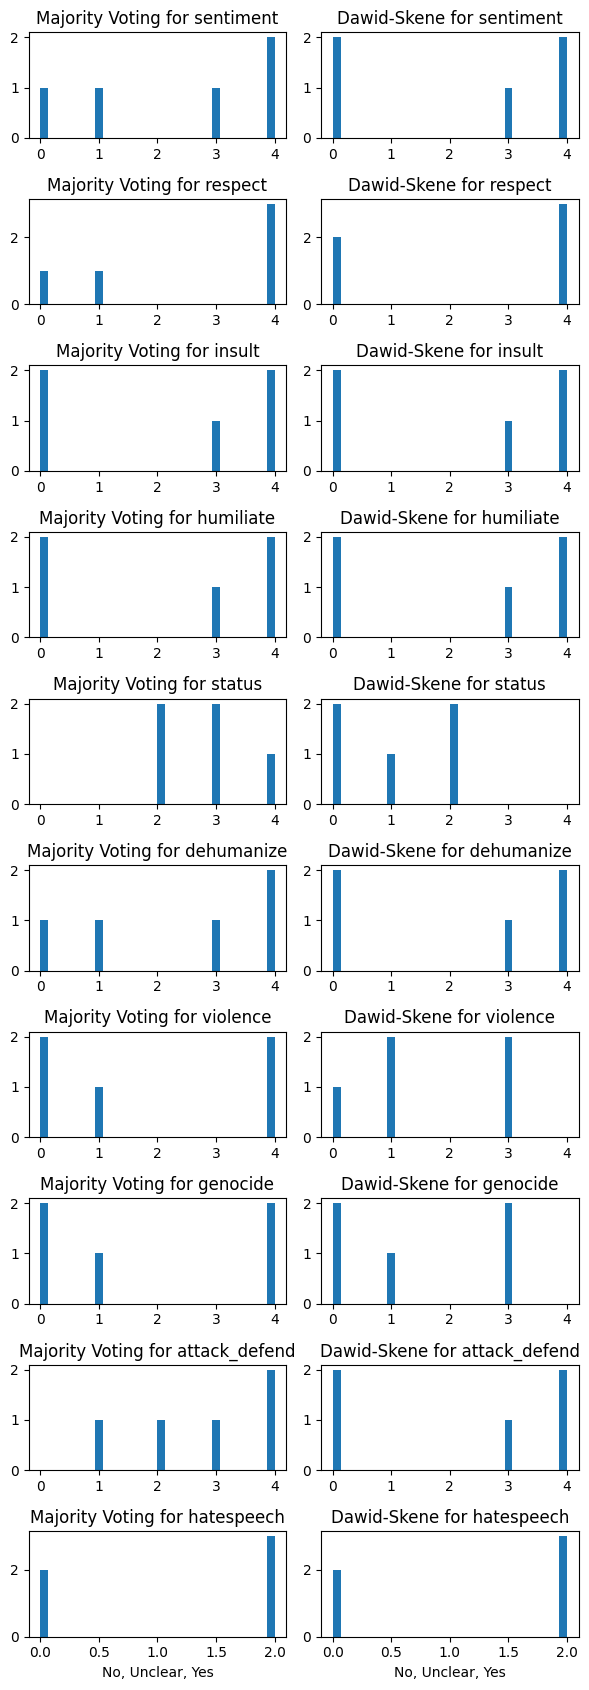

In [13]:
# Generate some random data for demonstration

# Set up the figure with a grid layout (3 rows, 4 columns)
fig, axes = plt.subplots(10, 2, figsize=(6, 17))

# Flatten the 2D array of axes for easier iteration
axes = axes.ravel()

# Create histograms in each subplot
i = 0
for axis in comment_annotations:
    if axis == 'hatespeech':
        # majority voting graph
        axes[i].hist(axes_results[axis], bins=30, range=[0, 2])
        axes[i].set_title('Majority Voting for ' + axis)
        axes[i].set_xlabel('No, Unclear, Yes')
        # axes[i].set_ylabel('Frequency')
        i += 1
        # Dawid-Skene graph
        axes[i].hist(ds_axes_results[axis], bins=30, range=[0, 2])
        axes[i].set_title('Dawid-Skene for ' + axis)
        axes[i].set_xlabel('No, Unclear, Yes')
        # axes[i].set_ylabel('Frequency')
        i += 1
    else:
        # majority voting graph
        axes[i].hist(axes_results[axis], bins=30, range=[0, 4])
        axes[i].set_title('Majority Voting for ' + axis)
        # axes[i].set_xlabel('Value')
        # axes[i].set_ylabel('Frequency')
        i += 1
        # Dawid-Skene graph
        axes[i].hist(ds_axes_results[axis], bins=30, range=[0, 4])
        axes[i].set_title('Dawid-Skene for ' + axis)
        # axes[i].set_xlabel('Value')
        # axes[i].set_ylabel('Frequency')
        i += 1

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.savefig("figures/maj_vote_d_s_small_data.pdf")

### 5. Running experiments

In [3]:
api_key = open("openai_api_key.txt", 'r').read() # API key needs to be in this txt file
model="gpt-4o-mini"
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", api_key))

In [8]:
synthetic_lm_data = []
demographics = ['gender', 'race', 'income', 'educ', 'ideology', 'age', 'sexuality', 'trans', 'religion']
axes = ['sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech']

for instance in tqdm(filtered_dataset['train']):
    synthetic_instance = {
        'comment_id': instance['comment_id'],
        'annotator_id': instance['annotator_id']
    }
    # get prompts
    system_prompt = get_demographic_system_prompt(instance, demographics)
    identities_survey_prompt = get_identities_survey_prompt(instance['text'])
    extra_surveys = get_extra_survey_prompts(axes)
    user_prompts = [identities_survey_prompt] + extra_surveys
    # get responses
    responses = openai_iter_generation(client, model, system_prompt, user_prompts)
    # add to results
    for axis, response in zip(axes, responses[1:]):
        num_response = response_to_num[response.strip()]
        synthetic_instance[axis] = num_response

    synthetic_lm_data.append(synthetic_instance)

100%|██████████| 27/27 [03:15<00:00,  7.25s/it]


### 6. Majority Voting with synthetic data

In [11]:
comment_id_to_text = {}
for instance in filtered_dataset['train']:
    if instance['comment_id'] not in comment_id_to_text.keys():
        comment_id_to_text[instance['comment_id']] = instance['text']

In [13]:
comment_id_to_data_synthetic = {}
for instance in synthetic_lm_data:
    if instance['comment_id'] not in comment_id_to_data_synthetic.keys():
        comment_id_to_data_synthetic[instance['comment_id']] = {'comment': comment_id_to_text[instance['comment_id']]}
        for axis in comment_annotations:
            comment_id_to_data_synthetic[instance['comment_id']][axis] = []
    for axis in comment_annotations:
            comment_id_to_data_synthetic[instance['comment_id']][axis].append(instance[axis])

# get data in axes format
axes_results_synthetic = {}
for axis in comment_annotations:
    axes_results_synthetic[axis] = []

# run majority voting
for id in comment_id_to_data_synthetic:
    results = get_majority_vote(comment_id_to_data_synthetic[id])
    for axis in comment_annotations:
        axes_results_synthetic[axis].append(results[axis])

(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([0.        , 0.13333333, 0.26666667, 0.4       , 0.53333333,
        0.66666667, 0.8       , 0.93333333, 1.06666667, 1.2       ,
        1.33333333, 1.46666667, 1.6       , 1.73333333, 1.86666667,
        2.        , 2.13333333, 2.26666667, 2.4       , 2.53333333,
        2.66666667, 2.8       , 2.93333333, 3.06666667, 3.2       ,
        3.33333333, 3.46666667, 3.6       , 3.73333333, 3.86666667,
        4.        ]),
 <BarContainer object of 30 artists>)

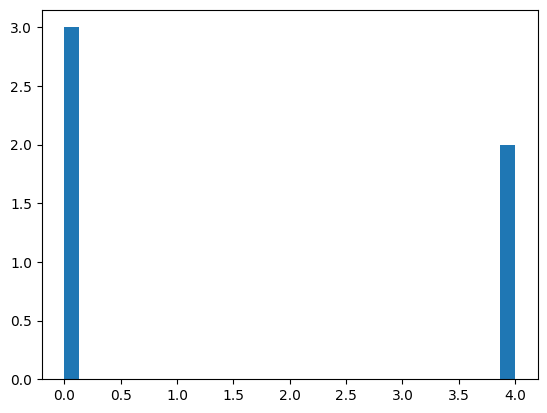

In [15]:
plt.hist(axes_results_synthetic['respect'], bins=30, range=[0, 4])

### 7. Dawid-Skene with synthetic data

In [16]:
# format data for dawid-skene code
ds_format_data_synthetic = {}
for axis in comment_annotations:
    ds_format_data_synthetic[axis] = get_ds_format(synthetic_lm_data, axis)

# run dawid-skene
dawid_skene_results_synthetic = {}
for axis in comment_annotations:
    dawid_skene_results_synthetic[axis] = run(ds_format_data_synthetic[axis])

# get argmax for each comment
ds_axes_results_synthetic = {}
for axis in comment_annotations:
    ds_axes_results_synthetic[axis] = [np.argmax(v) for k, v in dawid_skene_results_synthetic[axis].items()]

(array([2., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.    , 0.1333, 0.2667, 0.4   , 0.5333, 0.6667, 0.8   , 0.9333,
        1.0667, 1.2   , 1.3333, 1.4667, 1.6   , 1.7333, 1.8667, 2.    ,
        2.1333, 2.2667, 2.4   , 2.5333, 2.6667, 2.8   , 2.9333, 3.0667,
        3.2   , 3.3333, 3.4667, 3.6   , 3.7333, 3.8667, 4.    ]),
 <BarContainer object of 30 artists>)

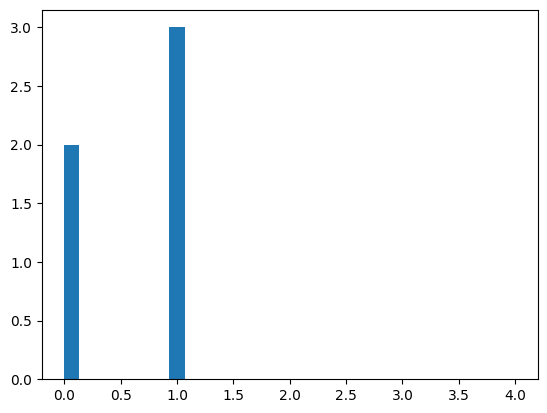

In [17]:
plt.hist(ds_axes_results_synthetic['hatespeech'], bins=30,  range=[0, 4])

### 8. Plotting synthetic data results

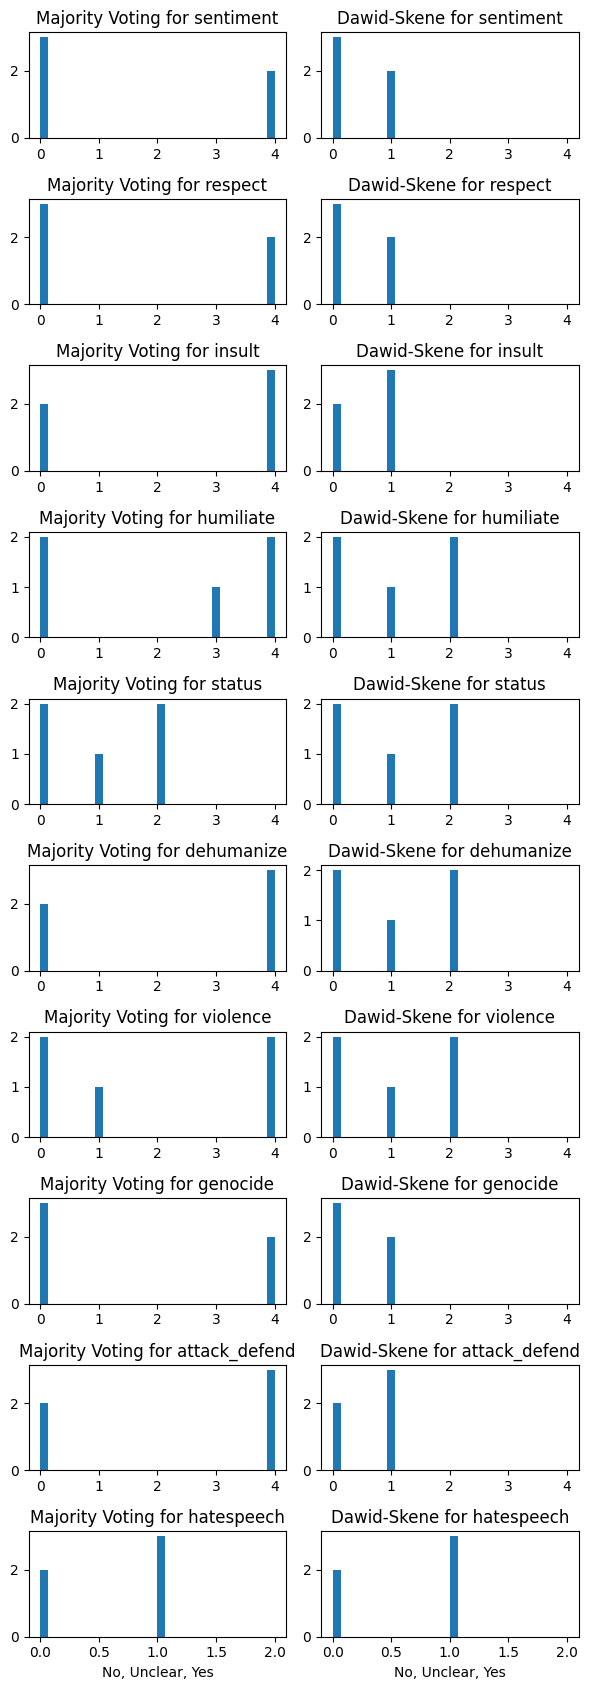

In [18]:
# Generate some random data for demonstration

# Set up the figure with a grid layout (3 rows, 4 columns)
fig, axes = plt.subplots(10, 2, figsize=(6, 17))

# Flatten the 2D array of axes for easier iteration
axes = axes.ravel()

# Create histograms in each subplot
i = 0
for axis in comment_annotations:
    if axis == 'hatespeech':
        # majority voting graph
        axes[i].hist(axes_results_synthetic[axis], bins=30, range=[0, 2])
        axes[i].set_title('Majority Voting for ' + axis)
        axes[i].set_xlabel('No, Unclear, Yes')
        # axes[i].set_ylabel('Frequency')
        i += 1
        # Dawid-Skene graph
        axes[i].hist(ds_axes_results_synthetic[axis], bins=30, range=[0, 2])
        axes[i].set_title('Dawid-Skene for ' + axis)
        axes[i].set_xlabel('No, Unclear, Yes')
        # axes[i].set_ylabel('Frequency')
        i += 1
    else:
        # majority voting graph
        axes[i].hist(axes_results_synthetic[axis], bins=30, range=[0, 4])
        axes[i].set_title('Majority Voting for ' + axis)
        # axes[i].set_xlabel('Value')
        # axes[i].set_ylabel('Frequency')
        i += 1
        # Dawid-Skene graph
        axes[i].hist(ds_axes_results_synthetic[axis], bins=30, range=[0, 4])
        axes[i].set_title('Dawid-Skene for ' + axis)
        # axes[i].set_xlabel('Value')
        # axes[i].set_ylabel('Frequency')
        i += 1

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.savefig("figures/maj_vote_d_s_small_data_synthetic.pdf")

### 9. Synthetic results with no demographic info

In [21]:
api_key = open("openai_api_key.txt", 'r').read() # API key needs to be in this txt file
model="gpt-4o-mini"
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", api_key))

In [22]:
synthetic_lm_data = []
demographics = ['gender', 'race', 'income', 'educ', 'ideology', 'age', 'sexuality', 'trans', 'religion']
axes = ['sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech']

for instance in tqdm(filtered_dataset['train']):
    synthetic_instance = {
        'comment_id': instance['comment_id'],
        'annotator_id': instance['annotator_id']
    }
    # get prompts
    system_prompt = "You are a helpful assistant."
    identities_survey_prompt = get_identities_survey_prompt(instance['text'])
    extra_surveys = get_extra_survey_prompts(axes)
    user_prompts = [identities_survey_prompt] + extra_surveys
    # get responses
    responses = openai_iter_generation(client, model, system_prompt, user_prompts)
    # add to results
    for axis, response in zip(axes, responses[1:]):
        num_response = response_to_num[response.strip()]
        synthetic_instance[axis] = num_response

    synthetic_lm_data.append(synthetic_instance)

100%|██████████| 27/27 [03:03<00:00,  6.78s/it]


### 10. Majority voting synthetic data, no demographic info

In [24]:
comment_id_to_text = {}
for instance in filtered_dataset['train']:
    if instance['comment_id'] not in comment_id_to_text.keys():
        comment_id_to_text[instance['comment_id']] = instance['text']

In [25]:
comment_id_to_data_synthetic = {}
for instance in synthetic_lm_data:
    if instance['comment_id'] not in comment_id_to_data_synthetic.keys():
        comment_id_to_data_synthetic[instance['comment_id']] = {'comment': comment_id_to_text[instance['comment_id']]}
        for axis in comment_annotations:
            comment_id_to_data_synthetic[instance['comment_id']][axis] = []
    for axis in comment_annotations:
            comment_id_to_data_synthetic[instance['comment_id']][axis].append(instance[axis])

# get data in axes format
axes_results_synthetic = {}
for axis in comment_annotations:
    axes_results_synthetic[axis] = []

# run majority voting
for id in comment_id_to_data_synthetic:
    results = get_majority_vote(comment_id_to_data_synthetic[id])
    for axis in comment_annotations:
        axes_results_synthetic[axis].append(results[axis])

(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([0.    , 0.1333, 0.2667, 0.4   , 0.5333, 0.6667, 0.8   , 0.9333,
        1.0667, 1.2   , 1.3333, 1.4667, 1.6   , 1.7333, 1.8667, 2.    ,
        2.1333, 2.2667, 2.4   , 2.5333, 2.6667, 2.8   , 2.9333, 3.0667,
        3.2   , 3.3333, 3.4667, 3.6   , 3.7333, 3.8667, 4.    ]),
 <BarContainer object of 30 artists>)

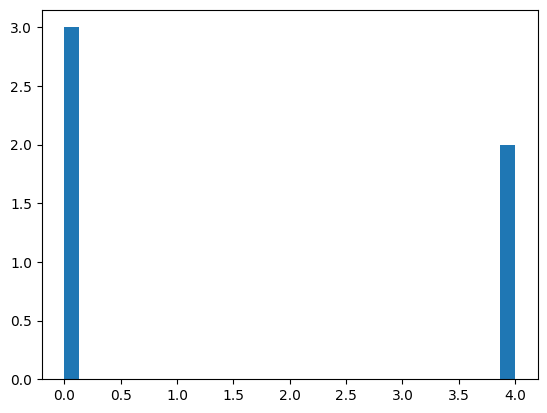

In [26]:
plt.hist(axes_results_synthetic['respect'], bins=30, range=[0, 4])

### 11. Dawid-skene synthetic data, no demographic info

In [27]:
# format data for dawid-skene code
ds_format_data_synthetic = {}
for axis in comment_annotations:
    ds_format_data_synthetic[axis] = get_ds_format(synthetic_lm_data, axis)

# run dawid-skene
dawid_skene_results_synthetic = {}
for axis in comment_annotations:
    dawid_skene_results_synthetic[axis] = run(ds_format_data_synthetic[axis])

# get argmax for each comment
ds_axes_results_synthetic = {}
for axis in comment_annotations:
    ds_axes_results_synthetic[axis] = [np.argmax(v) for k, v in dawid_skene_results_synthetic[axis].items()]

(array([2., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.    , 0.1333, 0.2667, 0.4   , 0.5333, 0.6667, 0.8   , 0.9333,
        1.0667, 1.2   , 1.3333, 1.4667, 1.6   , 1.7333, 1.8667, 2.    ,
        2.1333, 2.2667, 2.4   , 2.5333, 2.6667, 2.8   , 2.9333, 3.0667,
        3.2   , 3.3333, 3.4667, 3.6   , 3.7333, 3.8667, 4.    ]),
 <BarContainer object of 30 artists>)

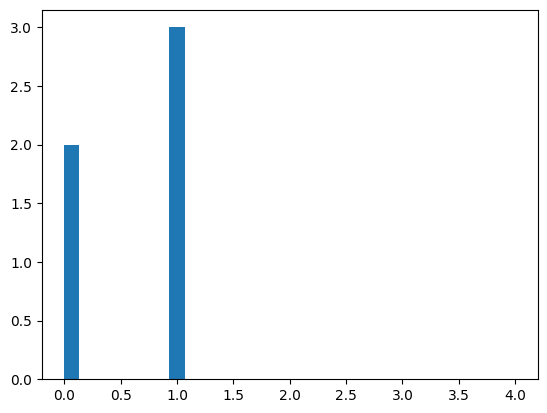

In [28]:
plt.hist(ds_axes_results_synthetic['hatespeech'], bins=30,  range=[0, 4])

### 12. Plotting synthetic data, no demographic info

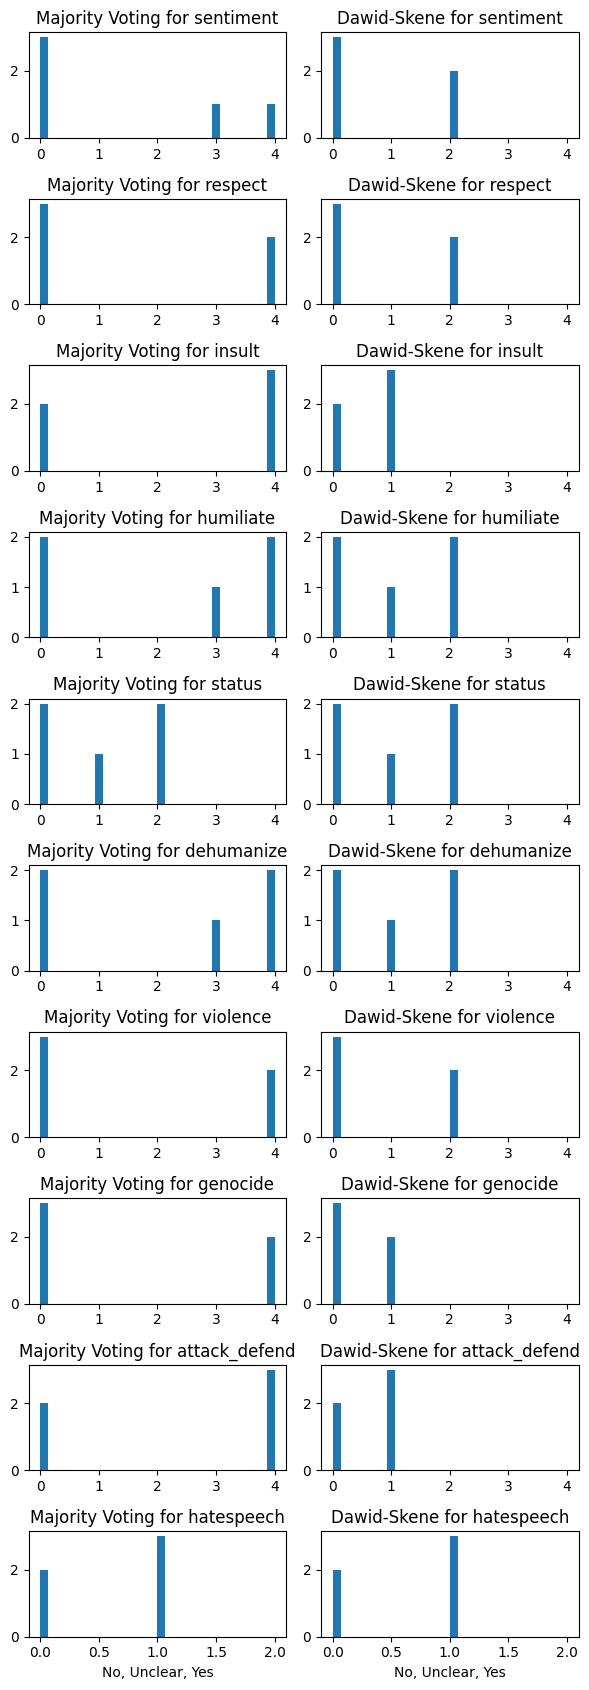

In [29]:
# Generate some random data for demonstration

# Set up the figure with a grid layout (3 rows, 4 columns)
fig, axes = plt.subplots(10, 2, figsize=(6, 17))

# Flatten the 2D array of axes for easier iteration
axes = axes.ravel()

# Create histograms in each subplot
i = 0
for axis in comment_annotations:
    if axis == 'hatespeech':
        # majority voting graph
        axes[i].hist(axes_results_synthetic[axis], bins=30, range=[0, 2])
        axes[i].set_title('Majority Voting for ' + axis)
        axes[i].set_xlabel('No, Unclear, Yes')
        # axes[i].set_ylabel('Frequency')
        i += 1
        # Dawid-Skene graph
        axes[i].hist(ds_axes_results_synthetic[axis], bins=30, range=[0, 2])
        axes[i].set_title('Dawid-Skene for ' + axis)
        axes[i].set_xlabel('No, Unclear, Yes')
        # axes[i].set_ylabel('Frequency')
        i += 1
    else:
        # majority voting graph
        axes[i].hist(axes_results_synthetic[axis], bins=30, range=[0, 4])
        axes[i].set_title('Majority Voting for ' + axis)
        # axes[i].set_xlabel('Value')
        # axes[i].set_ylabel('Frequency')
        i += 1
        # Dawid-Skene graph
        axes[i].hist(ds_axes_results_synthetic[axis], bins=30, range=[0, 4])
        axes[i].set_title('Dawid-Skene for ' + axis)
        # axes[i].set_xlabel('Value')
        # axes[i].set_ylabel('Frequency')
        i += 1

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.savefig("figures/maj_vote_d_s_small_data_synthetic_no_demographic.pdf")